In [ ]:
import torch
from torchvision.datasets import VOCSegmentation
from torch.utils.data import random_split

# 1. Download the combined train+val set
dataset = VOCSegmentation(root='data',
                          year='2012',
                          image_set='trainval',
                          download=True)

# 2. Compute split sizes (80/20)
total = len(dataset)
train_size = int(0.8 * total)
test_size  = total - train_size

# 3. Randomly split into train / test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total images: {total}")
print(f"Train images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")


100%|██████████| 1999639040/1999639040 [16:43<00:00, 1992714.93it/s]


Extracting data/VOCtrainval_11-May-2012.tar to data
Total images: 2913
Train images: 2330
Test images: 583


# EDA


In [25]:
from torchvision.datasets import VOCSegmentation
import numpy as np
import matplotlib.pyplot as plt

In [23]:
test_loader = dataset
VOC_CLASSES = [
    'background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
    'chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
    'sheep','sofa','train','tvmonitor'
]


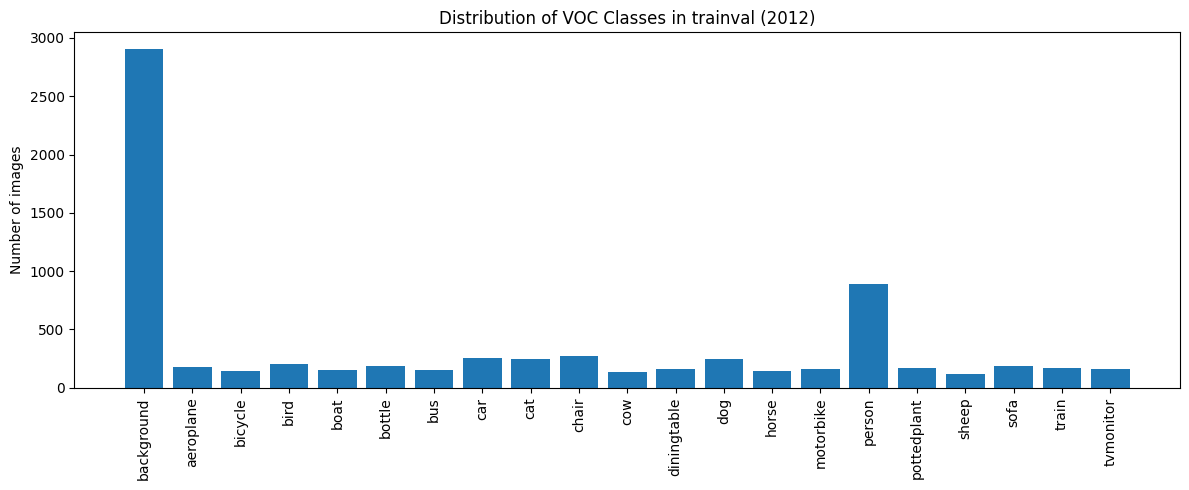

In [26]:
image_counts = {cls: 0 for cls in VOC_CLASSES}
for _, target in dataset:
    mask = np.array(target)  # H×W array of class‐indices
    # for each class index, check presence
    for idx, cls in enumerate(VOC_CLASSES):
        if (mask == idx).any():
            image_counts[cls] += 1

# 4. Prepare data for plotting
classes = list(image_counts.keys())
counts  = [image_counts[c] for c in classes]

# 5. Plot
plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Number of images')
plt.title('Distribution of VOC Classes in trainval (2012)')
plt.tight_layout()
plt.show()

Since the one image can have several labels, for now we decided to consider first entrance of image and we will see the distribution.


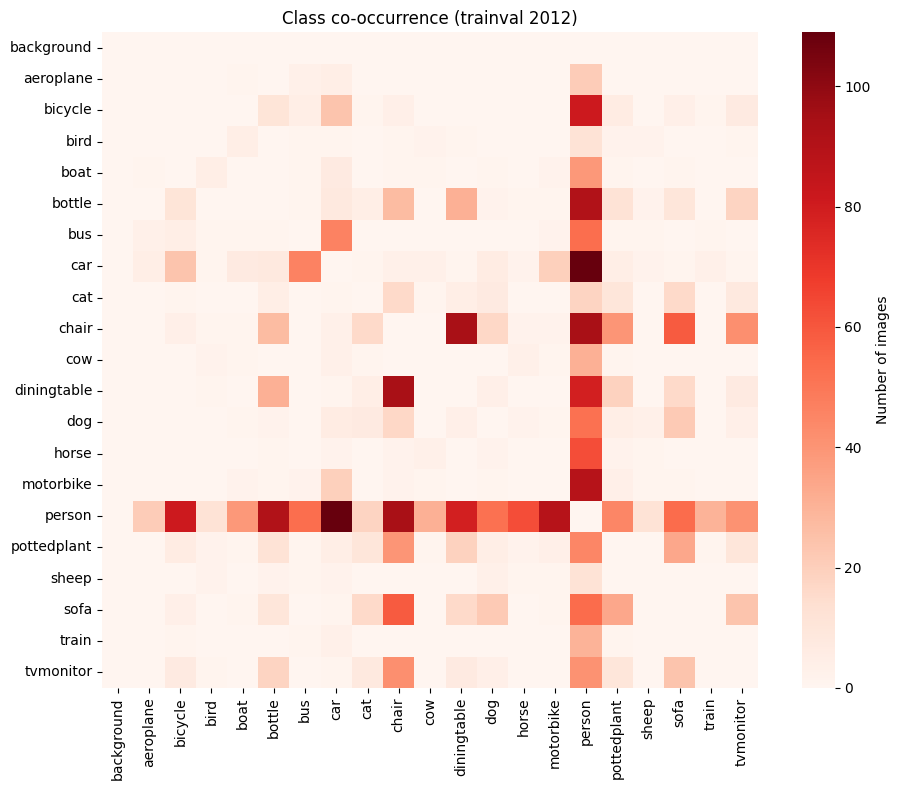

In [40]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import VOCSegmentation

n = len(VOC_CLASSES)
cooc = np.zeros((n, n), dtype=int)

for _, target in dataset:
    mask = np.array(target)
    uniq = np.unique(mask)
    # drop 0=background *if* you don’t want to count background co-occurrence
    # and drop anything ≥ len(VOC_CLASSES) (i.e. the 255 “ignore” label)
    valid = uniq[(uniq != 0) & (uniq < n)]
    
    # build co-occurrence for each pair
    for i, j in combinations(valid, 2):
        cooc[i, j] += 1
        cooc[j, i] += 1

# plot
plt.figure(figsize=(10,8))
sns.heatmap(cooc, 
            xticklabels=VOC_CLASSES, 
            yticklabels=VOC_CLASSES,
            cmap="Reds", 
            square=True,
            cbar_kws={'label': 'Number of images'})
plt.title('Class co-occurrence (trainval 2012)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

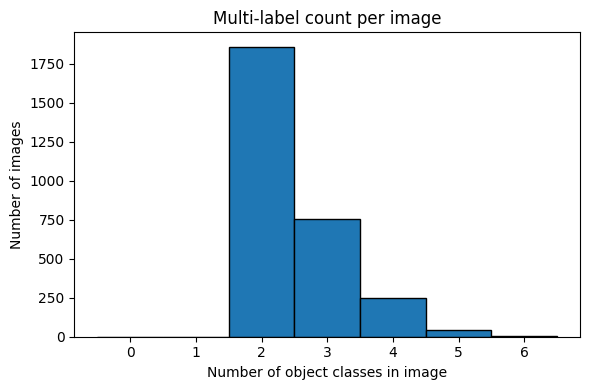

In [29]:
num_labels = []
for _, target in dataset:
    uniq = np.unique(np.array(target))
    uniq = uniq[uniq != 0]
    num_labels.append(len(uniq))

# 2. Convert to array for convenience
num_arr = np.array(num_labels)

# 3. Plot histogram
plt.figure(figsize=(6,4))
bins = np.arange(0, num_arr.max()+2) - 0.5
plt.hist(num_arr, bins=bins, edgecolor='k')
plt.xlabel('Number of object classes in image')
plt.ylabel('Number of images')
plt.title('Multi-label count per image')
plt.xticks(np.arange(0, num_arr.max()+1))
plt.tight_layout()
plt.show()


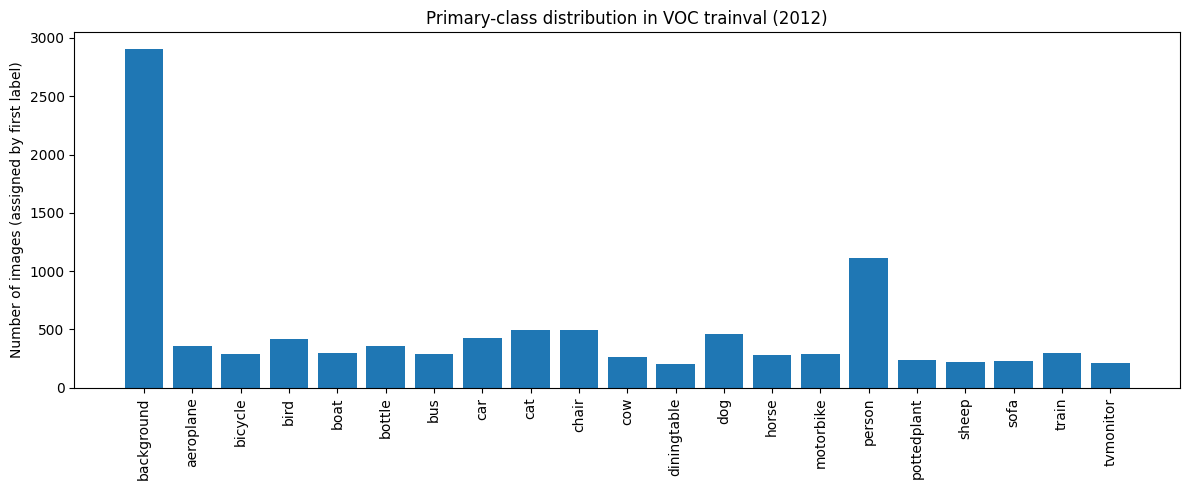

In [27]:
for _, target in dataset:
    mask = np.array(target)           # H×W array of class indices
    unique_idxs = np.unique(mask)     # sorted array of all classes in this image
    
    # filter out background (idx=0)
    non_bg = unique_idxs[unique_idxs != 0]
    if len(non_bg) > 0:
        first_cls_idx = non_bg[0]     # “first” class by index order
    else:
        first_cls_idx = 0             # if only background is present

    image_counts[VOC_CLASSES[first_cls_idx]] += 1

# 5. Plot the resulting distribution
classes = list(image_counts.keys())
counts  = [image_counts[c] for c in classes]

plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Number of images (assigned by first label)')
plt.title('Primary-class distribution in VOC trainval (2012)')
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import os

# 1) Load the raw text
path = "result/results.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read()

# 2) Split into sections per model
sections = text.split("Model: ")[1:]  # drop anything before the first

reports = {}
for sec in sections:
    lines = [l for l in sec.splitlines() if l.strip()]
    model_name = lines[0].strip()               # e.g. "resnet50"
    
    # find the header line ("precision  recall  f1-score")
    hdr_idx = next(i for i,l in enumerate(lines) 
                   if "precision" in l and "recall" in l)
    
    # next 20 lines are class rows
    class_lines = lines[hdr_idx+1 : hdr_idx+1+20]
    
    rows = []
    for ln in class_lines:
        parts = ln.split()
        cls       = parts[0]
        precision = float(parts[1])
        recall    = float(parts[2])
        f1_score  = float(parts[3])
        rows.append((cls, recall, f1_score))
    
    # build a DataFrame per model
    df = pd.DataFrame(rows, columns=["class","accuracy","f1"]).set_index("class")
    reports[model_name] = df

# 3) Combine into two wide tables
acc_df = pd.DataFrame({m: df["accuracy"] for m, df in reports.items()})
f1_df  = pd.DataFrame({m: df["f1"]       for m, df in reports.items()})

# 4) Display
print("=== Per-Class Accuracy (Recall) ===")
display(acc_df.style.format("{:.2f}"))

print("\n=== Per-Class F1 Score ===")
display(f1_df.style.format("{:.2f}"))


=== Per-Class Accuracy (Recall) ===


,resnet50,mobilenet_v3_large,shufflenet_v2_x1_0,efficientnet_b0,squeezenet1_1,wide_resnet50_2,convnext_tiny
class,,,,,,,
aeroplane,0.79,0.79,0.77,0.95,0.42,0.60,0.81
bicycle,0.82,0.84,0.87,0.95,0.42,0.45,0.66
bird,0.61,0.74,0.74,0.91,0.22,0.44,0.48
boat,0.82,0.93,0.73,0.89,0.30,0.45,0.84
bottle,0.89,0.87,0.92,0.90,0.63,0.31,0.79
bus,0.76,0.98,0.91,0.93,0.67,0.30,0.85
car,0.85,0.93,0.96,0.93,0.57,0.44,0.89
cat,0.44,0.61,0.88,0.88,0.04,0.53,0.88
chair,0.73,0.71,0.72,0.80,0.37,0.34,0.90



=== Per-Class F1 Score ===


,resnet50,mobilenet_v3_large,shufflenet_v2_x1_0,efficientnet_b0,squeezenet1_1,wide_resnet50_2,convnext_tiny
class,,,,,,,
aeroplane,0.79,0.80,0.86,0.95,0.43,0.57,0.86
bicycle,0.60,0.77,0.85,0.83,0.35,0.38,0.79
bird,0.63,0.75,0.76,0.85,0.27,0.32,0.61
boat,0.50,0.75,0.78,0.90,0.35,0.55,0.85
bottle,0.71,0.88,0.88,0.85,0.41,0.35,0.82
bus,0.79,0.88,0.92,0.95,0.54,0.44,0.86
car,0.85,0.82,0.89,0.92,0.46,0.44,0.92
cat,0.52,0.72,0.82,0.82,0.06,0.43,0.75
chair,0.60,0.71,0.71,0.79,0.36,0.39,0.66
